In [1]:
using Revise
using LinearAlgebra
using SparseArrays
using Pkg
using DelayDiffEq 
using Plots
using BenchmarkTools

In [2]:
using OpenQuantumSystems

┌ Info: Precompiling OpenQuantumSystems [90e503ea-487f-4e8e-81fe-8dcc9db25ac5]
└ @ Base loading.jl:1342


In [3]:
D(op1::Array, op2::Array) = abs(norm(op1 - op2))
D(x1::StateVector, x2::StateVector) = norm(x2 - x1)
D(op1::AbstractOperator, op2::AbstractOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))
D(op1::AbstractSuperOperator, op2::AbstractSuperOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))

HR = 0.01
shift = (2.0 * HR)
modes = [Mode(180., shift)]
mols = [
        Molecule([Mode(180., shift)], 3, [12500., 12700.]),
        Molecule([Mode(180., shift)], 3, [12500., 12700.])
    ]

aggCore = AggregateCore(mols)
for mol_i in 2:aggCore.molCount
    aggCore.coupling[mol_i, mol_i+1] = 50
    aggCore.coupling[mol_i+1, mol_i] = 50
end
agg = setupAggregate(aggCore)
aggCore = agg.core
aggTools = agg.tools
aggOperators = agg.operators

Ham_sys = agg.operators.Ham_sys
Ham_bath = agg.operators.Ham_bath
Ham_S = agg.operators.Ham_S
Ham_B = agg.operators.Ham_B
Ham_I = agg.operators.Ham_I
Ham_0 = agg.operators.Ham_0
Ham = agg.operators.Ham

basis = agg.tools.basis
indicesLen = agg.tools.bSize
indices = agg.tools.indices
indicesMap = agg.tools.indicesMap
FCFact = agg.tools.FCfactors
FCProd = agg.tools.FCproduct

Ham_0
Ham_0_lambda, Ham_0_S = eigen(Ham_0.data)
Ham_0_Sinv = inv(Ham_0_S)
Ham_0_lambda = diagm(Ham_0_lambda)
println("")

In [4]:
t_max = 0.05
t_count = 200
t0 = 0.
t_step = (t_max - t0) / (t_count)
tspan = [t0:t_step:t_max;]

T = 300
mu_array = [[2, 1]]
W0_1 = thermal_state(T, [[2, 1]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_2 = thermal_state(T, [[1, 2]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_3 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
W0_4 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
a1 = indicesMap[2][1]; a2 = indicesMap[2][end]
b1 = indicesMap[3][1]; b2 = indicesMap[3][end]
W0_3.data[a1:a2, b1:b2] = W0_2.data[b1:b2, b1:b2]
W0_4.data[b1:b2, a1:a2] = W0_2.data[b1:b2, b1:b2]
W0 = 0.8*W0_1 + 0.2*W0_2 + 0.1*W0_3 + 0.1*W0_4
W0 = DenseOperator(W0.basis_l, W0.basis_r, complex(W0.data))

# data = Matrix(Hermitian(rand(ComplexF64, indicesLen, indicesLen)))
# W0 = DenseOperator(basis, basis, data)
# normalize!(W0)

W0_bath = get_rho_bath(W0, aggCore, aggTools)
W0_bath = DenseOperator(W0_bath.basis_l, W0_bath.basis_r, complex(W0_bath.data))

rho0 = trace_bath(W0, aggCore, aggTools)
rho0 = DenseOperator(rho0.basis_l, rho0.basis_r, complex(rho0.data))

println("")

In [36]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 5
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
using OpenQuantumSystems
@time T, W_int_t = LvN_SI(
    W0,
    tspan,
    agg;
    reltol = 1e-10,
    abstol = 1e-10,
    alg = OrdinaryDiffEq.Tsit5(),
)

  2.192233 seconds (2.04 M allocations: 128.710 MiB, 2.49% gc time)


([0.0, 0.00025, 0.0005, 0.00075, 0.001, 0.00125, 0.0015, 0.00175, 0.002, 0.00225  …  0.04775, 0.048, 0.04825, 0.0485, 0.04875, 0.049, 0.04925, 0.0495, 0.04975, 0.05], Operator{GenericBasis{Vector{Int64}}, GenericBasis{Vector{Int64}}, Matrix{ComplexF64}}[Operator(dim=27x27)
  basis: Basis(dim=27)
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …        0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …        0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im           0.0+0.0im        0.0+0.0im
 0.

In [41]:
W_t_exact = zeros(ComplexF64, length(tspan), agg.tools.bSize, agg.tools.bSize)
t_i = 0

for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham, t)
    W = U_op * W0 * U_op'
    U_0_op = evolutionOperator(Ham_0, t)
    W = U_0_op' * W * U_0_op
    W_t_exact[t_i, :, :] = W.data
end

1 0.0
2 1.509634274250394e-9
3 2.1371434591117772e-9
4 1.0293809974382381e-9
5 6.25981093572427e-10
6 6.36630715382779e-11
7 1.2733778078624066e-10
8 1.0143178358764956e-10
9 2.553320053910848e-10
10 3.831980295273756e-10
11 2.8843402856560905e-11
12 1.138760950521021e-10
13 2.2144871481073062e-10
14 1.1011744064691796e-10
15 1.190217986067445e-10
16 3.2434263558415494e-10
17 2.022211988021346e-10
18 8.031261302805224e-11
19 1.878636185261588e-10
20 2.8674773950037364e-10
21 7.883093747101424e-11
22 1.390347814984265e-10
23 3.682701357143209e-10
24 1.583793465280276e-10
25 1.087661603785555e-10
26 2.608276692108471e-10
27 3.197122779636185e-10
28 8.037936676295533e-11
29 1.5712133876500238e-10
30 4.0055499471629773e-10
31 1.8376101712593753e-10
32 1.197986739906936e-10
33 2.6721139075306594e-10
34 3.7882877677548885e-10
35 9.194338741637962e-11
36 1.7374355889893438e-10
37 4.105261405973293e-10
38 2.6253827630658174e-10
39 1.1950381050509878e-10
40 2.2971194006198207e-10
41 4.449238177

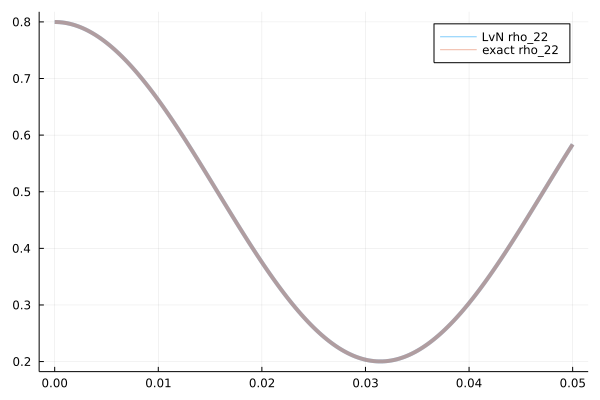

In [42]:

elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)

for t_i in 1:length(tspan)
    # rho_t[t_i, :, :] = rho_int_t[t_i].data
    rho_t[t_i, :, :] = trace_bath(W_int_t[t_i].data, aggCore, aggTools)
    rho_t_exact[t_i, :, :] = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t[:, 2, 2]), label="LvN rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

In [13]:
using OpenQuantumSystems
include("test_liouville.jl")


Test Summary: | Pass  Total
liouville     |   11     11


Test.DefaultTestSet("liouville", Any[], 11, false, false)

In [8]:
names = [
    "test_operators_dense.jl",
    "test_superoperators.jl",
    "test_metrics.jl",
    "test_molecules.jl",
    "test_aggregateCore.jl",
    "test_aggregateTools.jl",
    "test_aggregateOperators.jl",
    "test_aggregate.jl",
    "test_evolution.jl",
    "test_schroedinger.jl",
    "test_liouville.jl",
    "test_interaction_picture.jl",
    "test_master_exact.jl",
    "test_trace.jl",
    "test_initial_state.jl",
    "test_memory_kernel.jl",
    "test_master_ansatz.jl",
]

for name in names
    include(name)
end

Test Summary:   | Pass  Total
operators dense |    6      6
Test Summary:  | Pass  Total
superoperators |    2      2
Test Summary: | Pass  Total
metrics       |   19     19
Test Summary: | Pass  Total
molecules     |   20     20
Test Summary: | Pass  Total
aggregateCore |   14     14
Test Summary:  | Pass  Total
aggregateTools |   12     12
Test Summary:      | Pass  Total
aggregateOperators |    7      7
Test Summary: | Pass  Total
aggregate     |    3      3
Test Summary: | Pass  Total
evolution     |   54     54
Test Summary: | Pass  Total
schroedinger  |   25     25
Test Summary: | Pass  Total
liouville     |   11     11
Test Summary:       | Pass  Total
interaction picture |    9      9
Test Summary: |
master        | No tests
Test Summary: | Pass  Total
trace         |   41     41
Test Summary: | Pass  Total
initial state |    8      8
Test Summary: | Pass  Total
memory kernel |   51     51
Test Summary: |
master ansatz | No tests
